In [ ]:
# ===================================================================
#
#        NOTEBOOK 02: ANALYSIS AND PUBLICATION RESULTS
#
# ===================================================================
#
# AUTHORS: Alessandra Potenza, Camilla Sed
# PROJECT: Music Genre Classification on GTZAN
#
# PURPOSE:
# This notebook is dedicated to the analysis of the model training
# tournament conducted in Notebook 01. It does NOT perform any training.
# Its sole responsibility is to:
#   1. Load the summary of the training tournament.
#   2. Identify the champion architecture based on performance.
#   3. Load the pre-trained champion model file.
#   4. Generate publication-quality visualizations and analyses:
#      - Comparative performance bar charts.
#      - Detailed confusion matrix for the champion model.
#      - t-SNE visualization of the champion's learned feature embeddings.
#      - Key performance metrics table.
#
# ===================================================================

# ===================================================================
# CELL 1: SETUP AND ENVIRONMENT CONFIGURATION
# ===================================================================
# This cell imports necessary libraries and defines the project's
# directory structure, ensuring that we can locate the results
# generated by the training notebook.

import os
import sys
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import keras as keras
from keras import layers, models, optimizers, callbacks, regularizers
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE

# --- Define Project Paths ---
# Assume the notebook is in a 'notebooks' directory, one level down from the root.
# This makes the paths robust.
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

REPORTS_PATH = os.path.join(PROJECT_ROOT, 'reports')
MODELS_PATH = os.path.join(PROJECT_ROOT, 'models/ale')
PROCESSED_DATA_PATH = os.path.join(PROJECT_ROOT, 'data', 'processed')

# --- Matplotlib and Seaborn Styling for Publication Quality ---
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.dpi'] = 100

print("✅ Environment setup complete. Paths configured and styles set.")
print(f"Project Root: {PROJECT_ROOT}")

2025-07-26 13:13:10.579090: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-26 13:13:10.588319: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753528390.598350   31182 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753528390.601556   31182 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753528390.609143   31182 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

✅ Environment setup complete. Paths configured and styles set.
Project Root: /home/alepot55/Desktop/projects/naml_project


In [2]:
# ===================================================================
# CELL 2: LOAD DATA AND IDENTIFY CHAMPION MODEL
# ===================================================================
# This cell loads the results of our comprehensive model tournament
# and identifies the top-performing model, which will be the focus
# of our subsequent, in-depth analysis.

# --- Load Training Summary ---
summary_path = os.path.join(REPORTS_PATH, 'training_summary.csv')
try:
    results_df = pd.read_csv(summary_path)
    print("✅ Training summary loaded successfully.")
except FileNotFoundError:
    raise RuntimeError(f"❌ ERROR: Summary file not found at '{summary_path}'. Please run Notebook 01 first.")

# --- Identify and Announce the Champion ---
champion_info = results_df.sort_values(by='Best_Val_Accuracy', ascending=False).iloc[0]
champion_model_name = champion_info['Model']
champion_test_accuracy = champion_info['Test_Accuracy']

print("\n--- Model Tournament Leaderboard ---")
print(results_df.sort_values(by='Best_Val_Accuracy', ascending=False).to_markdown(index=False))

print(f"\n🏆 CHAMPION IDENTIFIED: '{champion_model_name}'")
print(f"   - Best Validation Accuracy: {champion_info['Best_Val_Accuracy']:.4f}")
print(f"   - Final Test Accuracy:      {champion_test_accuracy:.4f}")

# --- Load Supporting Data (Labels and Test Set for Analysis) ---
try:
    # We only need the test set and the label encoder for our analysis
    X_test = np.load(os.path.join(PROCESSED_DATA_PATH, 'X_test.npy'))
    y_test = np.load(os.path.join(PROCESSED_DATA_PATH, 'y_test.npy')) # Integer labels
    with open(os.path.join(PROCESSED_DATA_PATH, 'label_encoder.pkl'), 'rb') as f:
        label_encoder = pickle.load(f)
    class_labels = label_encoder.classes_
    print("\n✅ Test data and label encoder loaded for analysis.")
except FileNotFoundError:
    raise RuntimeError("❌ ERROR: Test data files not found. Please ensure the data pre-processing was completed.")

✅ Training summary loaded successfully.

--- Model Tournament Leaderboard ---
| Model                 |   Test_Accuracy |   Best_Val_Accuracy |   Epochs_Run |
|:----------------------|----------------:|--------------------:|-------------:|
| Efficient_VGG         |          0.8205 |              0.8375 |           43 |
| PaperCNN_Lite         |          0.8105 |              0.831  |           39 |
| ResSE_AudioCNN        |          0.8175 |              0.8275 |           50 |
| UNet_Audio_Classifier |          0.834  |              0.827  |           45 |
| SeparableResSE_CNN    |          0.8145 |              0.8205 |           34 |
| SE_AudioCNN           |          0.822  |              0.816  |           41 |

🏆 CHAMPION IDENTIFIED: 'Efficient_VGG'
   - Best Validation Accuracy: 0.8375
   - Final Test Accuracy:      0.8205

✅ Test data and label encoder loaded for analysis.


/tmp/ipykernel_31182/2514458968.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(


✅ Comparative performance chart saved to: /home/alepot55/Desktop/projects/naml_project/reports/comparative_performance_barchart.png


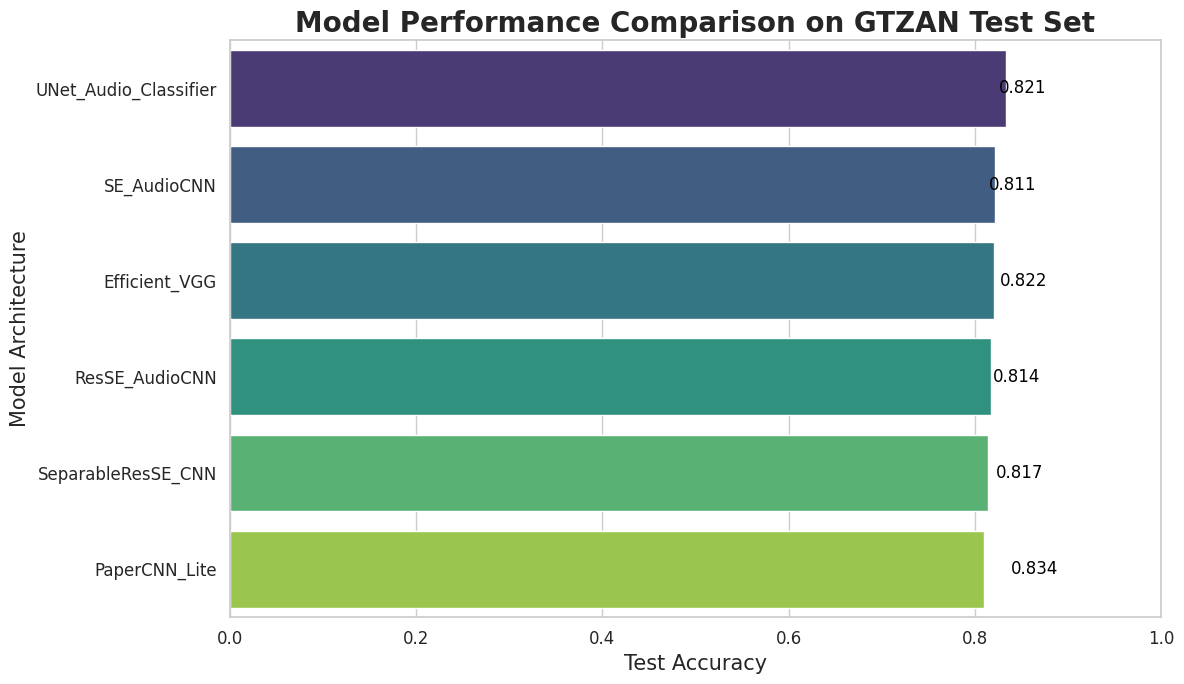

In [3]:
# ===================================================================
# CELL 3: VISUALIZATION 1 - COMPARATIVE PERFORMANCE
# ===================================================================
# This visualization provides a high-level overview of our experiment,
# clearly showing how the different architectures performed relative
# to one another.

# --- Sort dataframe for clear visualization ---
df_sorted = results_df.sort_values('Test_Accuracy', ascending=False)

# --- Create the Bar Plot ---
plt.figure(figsize=(12, 7))
bar_plot = sns.barplot(
    x='Test_Accuracy',
    y='Model',
    data=df_sorted,
    palette='viridis',
    orient='h'
)

# --- Add annotations and labels for clarity ---
for index, row in df_sorted.iterrows():
    bar_plot.text(
        row.Test_Accuracy + 0.005,
        index,
        f"{row.Test_Accuracy:.3f}",
        color='black',
        ha="left",
        va='center'
    )

plt.title('Model Performance Comparison on GTZAN Test Set', fontsize=20, weight='bold')
plt.xlabel('Test Accuracy', fontsize=15)
plt.ylabel('Model Architecture', fontsize=15)
plt.xlim(0, 1.0)
plt.tight_layout()

# --- Save the Figure for the Publication ---
fig_path = os.path.join(REPORTS_PATH, 'comparative_performance_barchart.png')
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✅ Comparative performance chart saved to: {fig_path}")

plt.show()

In [4]:
# ===================================================================
# CELL 4: DEEP DIVE - ANALYSIS OF THE CHAMPION MODEL
# ===================================================================
# This cell focuses exclusively on the champion model. We load its best
# weights and perform detailed analyses to understand its behavior.

# --- Load the Pre-trained Champion Model ---
champion_model_path = os.path.join(MODELS_PATH, f"{champion_model_name}_best.keras")
print(f"Loading weights for champion model from: {champion_model_path}")
try:
    # Using custom_objects handles any special layers like PReLU automatically
    model = keras.models.load_model(
        champion_model_path,
        custom_objects={'PReLU': layers.PReLU}
    )
    print("\n✅ Champion model loaded successfully.")
    model.summary()
except Exception as e:
    raise RuntimeError(f"❌ ERROR: Could not load the model. Error: {e}")

# --- Generate Predictions for Detailed Analysis ---
print("\nGenerating predictions on the test set...")
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Ensure y_true_classes are the integer labels
y_true_classes = y_test

Loading weights for champion model from: /home/alepot55/Desktop/projects/naml_project/models/ale/Efficient_VGG_best.keras


I0000 00:00:1753528392.338501   31182 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1781 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9



✅ Champion model loaded successfully.


Model: "UNet_Audio_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu (PReLU)                 │ (None, 128, 128, 32)   │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_1 (PReLU)               │ (None, 128, 128, 32)   │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_2 (PReLU)               │ (None, 64, 64, 64)     │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_3 (PReLU)               │ (None, 64, 64, 64)     │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_4 (PReLU)               │ (None, 32, 32, 128)    │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_5 (PReLU)               │ (None, 32, 32, 128)    │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             

 Total params: 3,530,432 (13.47 MB)

 Trainable params: 1,176,170 (4.49 MB)

 Non-trainable params: 1,920 (7.50 KB)

 Optimizer params: 2,352,342 (8.97 MB)


Generating predictions on the test set...


I0000 00:00:1753528393.271995   31387 service.cc:152] XLA service 0x7d151c01f0b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753528393.272010   31387 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2025-07-26 13:13:13.277958: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753528393.364014   31387 cuda_dnn.cc:529] Loaded cuDNN version 90300


37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

I0000 00:00:1753528395.204608   31387 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step


✅ Confusion matrix saved to: /home/alepot55/Desktop/projects/naml_project/reports/confusion_matrix_Efficient_VGG.png


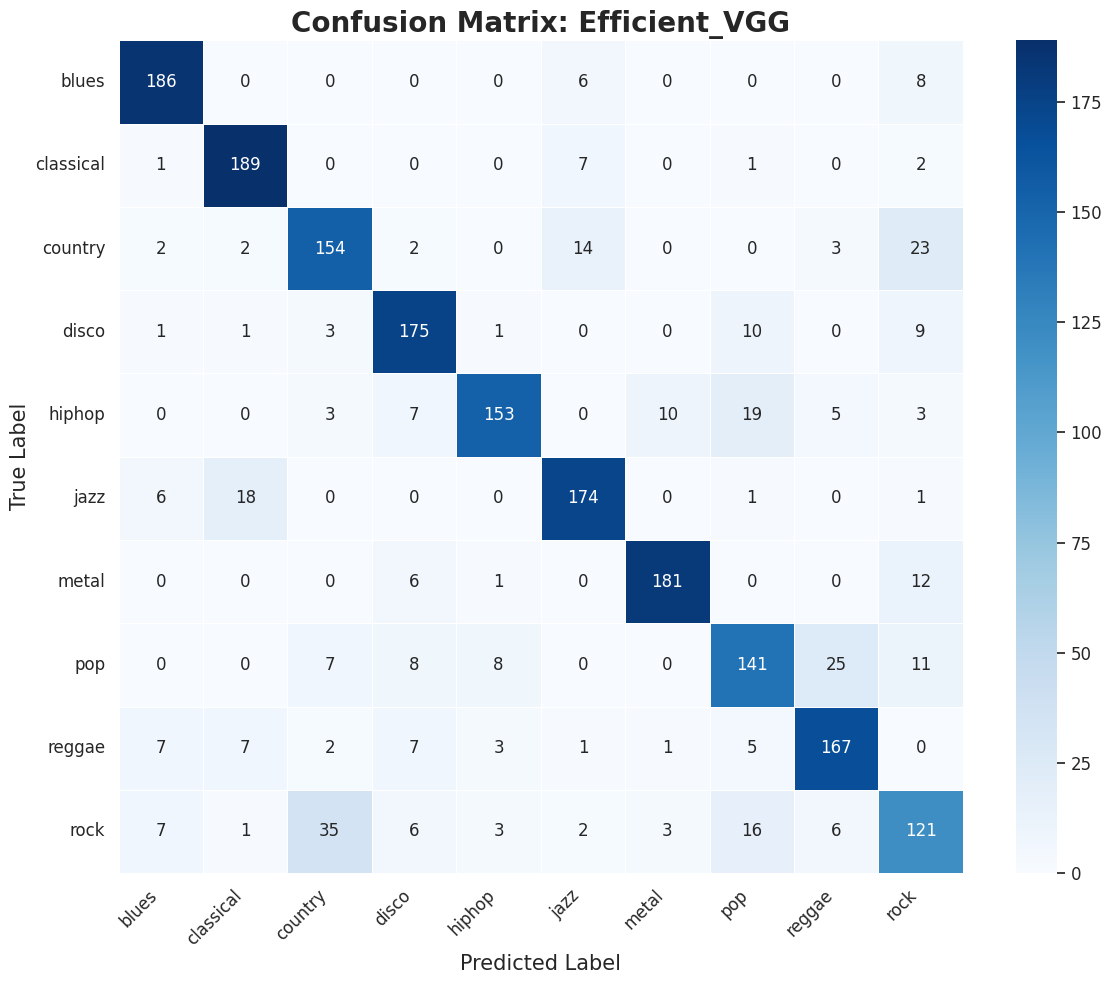


--- Detailed Classification Report ---
              precision    recall  f1-score   support

       blues       0.89      0.93      0.91       200
   classical       0.87      0.94      0.90       200
     country       0.75      0.77      0.76       200
       disco       0.83      0.88      0.85       200
      hiphop       0.91      0.77      0.83       200
        jazz       0.85      0.87      0.86       200
       metal       0.93      0.91      0.92       200
         pop       0.73      0.70      0.72       200
      reggae       0.81      0.83      0.82       200
        rock       0.64      0.60      0.62       200

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000


✅ Classification report saved to: /home/alepot55/Desktop/projects/naml_project/reports/classification_report_Efficient_VGG.txt


In [5]:
# ===================================================================
# CELL 5: VISUALIZATION 2 - CHAMPION'S CONFUSION MATRIX
# ===================================================================
# The confusion matrix provides a granular view of the model's
# performance, showing which genres are easily classified and
# which ones are being confused.

# --- Compute the confusion matrix ---
cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

# --- Plot the heatmap ---
plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linewidths=.5)
plt.title(f'Confusion Matrix: {champion_model_name}', fontsize=20, weight='bold')
plt.ylabel('True Label', fontsize=15)
plt.xlabel('Predicted Label', fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# --- Save the Figure for the Publication ---
fig_path = os.path.join(REPORTS_PATH, f'confusion_matrix_{champion_model_name}.png')
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✅ Confusion matrix saved to: {fig_path}")

plt.show()

# --- Print Classification Report for Precision/Recall/F1-Score ---
print("\n--- Detailed Classification Report ---")
report = classification_report(y_true_classes, y_pred_classes, target_names=class_labels)
print(report)

# Save report to a text file
report_path = os.path.join(REPORTS_PATH, f'classification_report_{champion_model_name}.txt')
with open(report_path, 'w') as f:
    f.write(report)
print(f"\n✅ Classification report saved to: {report_path}")


Extracting bottleneck features for t-SNE visualization...
Identified bottleneck layer for feature extraction: 'keras_tensor_53'
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Extracted feature shape: (2000, 16, 16, 256)
Flattened feature shape for t-SNE: (2000, 65536)

Running t-SNE... (this may take a few minutes)
✅ t-SNE computation complete.
✅ t-SNE plot saved to: /home/alepot55/Desktop/projects/naml_project/reports/tsne_visualization_Efficient_VGG.png


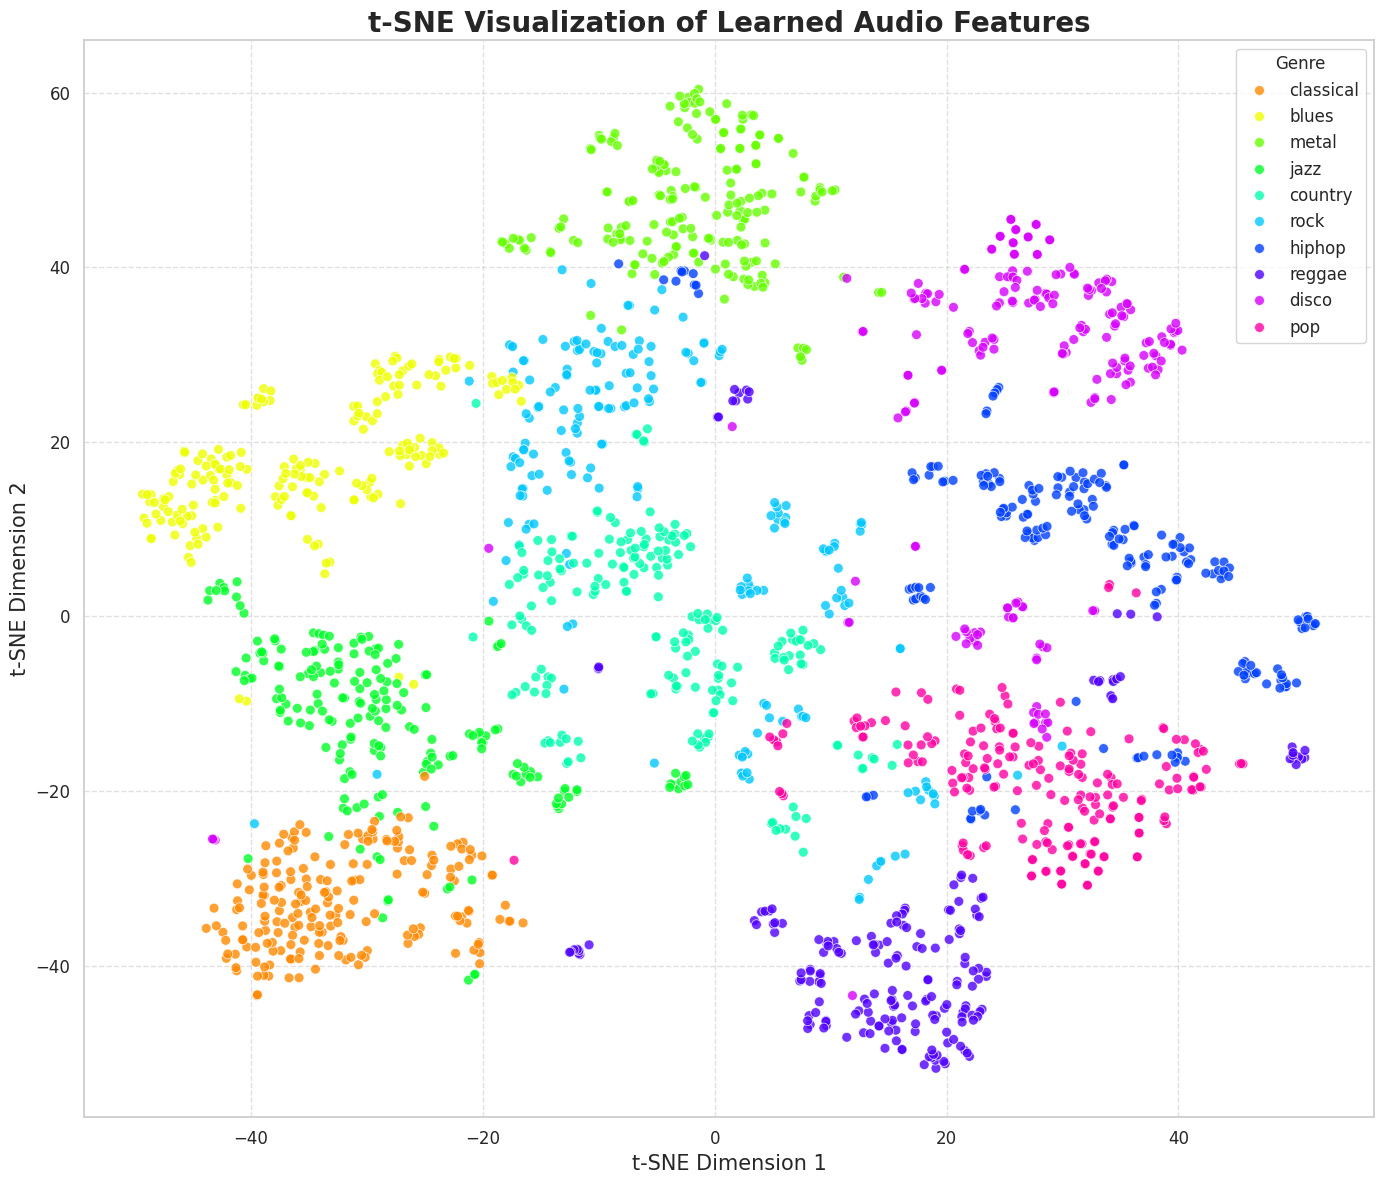



🎉 ANALYSIS NOTEBOOK COMPLETE. All figures and reports have been generated and saved. 🎉


In [6]:
# ===================================================================
# CELL 6: VISUALIZATION 3 - T-SNE OF LEARNED FEATURES
# ===================================================================
# This visualization helps us "see" the feature space learned by the
# model's bottleneck layer. Well-separated clusters indicate that
# the model has learned discriminative features for different genres.

print("\nExtracting bottleneck features for t-SNE visualization...")

# --- Create a feature extractor model ---
# A robust way to find the bottleneck is to get the input of the final
# classification head (the GlobalAveragePooling2D layer).
try:
    gap_layer = next(l for l in reversed(model.layers) if isinstance(l, layers.GlobalAveragePooling2D))
    feature_extractor = models.Model(inputs=model.input, outputs=gap_layer.input)
    print(f"Identified bottleneck layer for feature extraction: '{gap_layer.input.name}'")
except StopIteration:
    raise RuntimeError("Could not find a GlobalAveragePooling2D layer to create the feature extractor.")

# --- Extract features and run t-SNE ---
features = feature_extractor.predict(X_test)
print(f"Extracted feature shape: {features.shape}")

# Flatten the features if they are not already 2D (e.g., (N, H, W, C) -> (N, H*W*C))
if features.ndim > 2:
    features = features.reshape(features.shape[0], -1)
print(f"Flattened feature shape for t-SNE: {features.shape}")

print("\nRunning t-SNE... (this may take a few minutes)")
# ===================================================================
# *** FIX: Replaced deprecated 'n_iter' with 'max_iter' ***
# ===================================================================
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
tsne_features = tsne.fit_transform(features)
print("✅ t-SNE computation complete.")

# --- Create a DataFrame for plotting ---
tsne_df = pd.DataFrame(tsne_features, columns=['TSNE1', 'TSNE2'])
tsne_df['genre'] = label_encoder.inverse_transform(y_true_classes)

# --- Plot the scatterplot ---
plt.figure(figsize=(14, 12))
sns.scatterplot(
    data=tsne_df,
    x='TSNE1',
    y='TSNE2',
    hue='genre',
    palette=sns.color_palette("hsv", n_colors=len(class_labels)),
    alpha=0.8,
    s=50
)
plt.title('t-SNE Visualization of Learned Audio Features', fontsize=20, weight='bold')
plt.xlabel('t-SNE Dimension 1', fontsize=15)
plt.ylabel('t-SNE Dimension 2', fontsize=15)
plt.legend(loc='best', title='Genre')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# --- Save the Figure for the Publication ---
fig_path = os.path.join(REPORTS_PATH, f'tsne_visualization_{champion_model_name}.png')
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✅ t-SNE plot saved to: {fig_path}")

plt.show()

print("\n\n🎉 ANALYSIS NOTEBOOK COMPLETE. All figures and reports have been generated and saved. 🎉")